In [50]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 4060

True
NVIDIA GeForce RTX 4060 Laptop GPU


In [51]:
from torchvision import transforms

# Transformaciones para entrenamiento (aumentos + normalización)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0,
                            translate=(0.05, 0.05)),  # equivalente a width/height_shift
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Transformaciones para validación y test (solo reescalado + normalización)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [52]:
import os, math, numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# rutas (según tu estructura)
# lo que tenías (mal): BASE_DIR = os.path.join("002cancer")
BASE_DIR = os.path.join("..", "002_cancer")  # desde /notebooks sube a ../002_cancer
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

# parámetros que me pediste
CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
EPOCHS  = 20
TEST_MAX_SAMPLES = 2000
SEED    = 42

# dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:",DEVICE)
torch.manual_seed(SEED)
np.random.seed(SEED)

Usando dispositivo: cuda


In [53]:
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets

# --- Comprobación flexible ---
HAS_VAL = os.path.isdir(VAL_DIR)
assert os.path.isdir(TRAIN_DIR), f"Falta el directorio train: {TRAIN_DIR}"
assert os.path.isdir(TEST_DIR),  f"Falta el directorio test:  {TEST_DIR}"
print(f"Estructura: train ✅ | val {'✅' if HAS_VAL else '❌ (se hará split 80/20)'} | test ✅")

# --- Datasets y DataLoaders ---
# OJO: aquí asumo que ya tienes definidos `train_transforms` y `val_test_transforms`
# (ToTensor -> GaussianBlur -> Normalize con mean/std calculados en train)

if HAS_VAL:
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
else:
    # Split 80/20 desde train manteniendo transforms distintos para cada subset
    base_train = datasets.ImageFolder(TRAIN_DIR)            # sin transforms para sacar índices
    n_total = len(base_train)
    n_val   = int(0.2 * n_total)
    n_train = n_total - n_val
    g = torch.Generator().manual_seed(SEED)
    train_subset, val_subset = random_split(base_train, [n_train, n_val], generator=g)

    # Reconstruimos datasets con transforms distintos usando los mismos índices
    train_ds = Subset(datasets.ImageFolder(TRAIN_DIR, transform=train_transforms), train_subset.indices)
    val_ds   = Subset(datasets.ImageFolder(TRAIN_DIR, transform=val_test_transforms), val_subset.indices)

# Clases detectadas
classes = train_ds.dataset.classes if isinstance(train_ds, Subset) else train_ds.classes
print("Clases detectadas:", classes)
assert len(classes) == 2, "Debe haber exactamente 2 clases (binario)."

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2)

Estructura: train ✅ | val ❌ (se hará split 80/20) | test ✅
Clases detectadas: ['Benign', 'Malignant']


In [54]:
import torch
import torch.nn as nn

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

class CompactCNN(nn.Module):
    """
    CNN pequeña con bloques Conv-BN-ReLU, pooling progresivo y
    AdaptiveAvgPool2d(1) para ser robusta al tamaño de entrada.
    Salida: logits de tamaño (N, CLASSES).
    """
    def __init__(self, in_ch=INPUT_CH, num_classes=CLASSES):
        super().__init__()
        # Etapa 1: 3->32
        self.stage1 = nn.Sequential(
            ConvBNReLU(in_ch, 32),
            ConvBNReLU(32, 32),
            nn.MaxPool2d(2),          # /2
            nn.Dropout(0.10),
        )
        # Etapa 2: 32->64
        self.stage2 = nn.Sequential(
            ConvBNReLU(32, 64),
            ConvBNReLU(64, 64),
            nn.MaxPool2d(2),          # /4 acumulado
            nn.Dropout(0.15),
        )
        # Etapa 3: 64->128
        self.stage3 = nn.Sequential(
            ConvBNReLU(64, 128),
            ConvBNReLU(128, 128),
            nn.MaxPool2d(2),          # /8 acumulado
            nn.Dropout(0.20),
        )
        # Etapa 4: 128->128 (un poco más de capacidad)
        self.stage4 = nn.Sequential(
            ConvBNReLU(128, 128),
            nn.MaxPool2d(2),          # /16 acumulado
            nn.Dropout(0.25),
        )

        # Pooling a 1x1 -> vector de 128 dim sin importar HxW de entrada
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Clasificador
        self.classifier = nn.Sequential(
            nn.Flatten(),             # -> (N, 128)
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.40),
            nn.Linear(128, num_classes)  # logits
        )

        self._init_weights()


    def _init_weights(self):
        # Kaiming/He init para conv y fan_out para lineales
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x  # (N, CLASSES)

# Instanciar y preparar optimizador/criterio (CrossEntropy para 2 clases)
model = CompactCNN(in_ch=INPUT_CH, num_classes=CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Utilidad: nº de parámetros
def count_params(m): 
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print(model)
print(f"Parámetros entrenables: {count_params(model):,}")

CompactCNN(
  (stage1): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): ConvBNReLU(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (stage2): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): ConvBNReLU(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [55]:
# 4) Funciones de entrenamiento y evaluación por epoch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch

def run_epoch(dataloader, training=True, amp=True, grad_clip=None, scheduler=None, step_on_batch=False):
    """
    Ejecuta un epoch de train/val.
    Devuelve: avg_loss, acc, (y_true_all, y_pred_all, y_prob1_all)
      - y_prob1_all = probabilidad de la clase 1 (para AUC)
    Parámetros:
      amp:         mixed precision si hay CUDA
      grad_clip:   valor float para clip de gradiente (p.ej. 1.0) o None
      scheduler:   opcional, StepLR/CosineAnnealing..., step al final del epoch
      step_on_batch: si True, hace scheduler.step() por batch (OneCycle, etc.)
    """
    model.train() if training else model.eval()

    total, correct, total_loss = 0, 0, 0.0
    all_true, all_pred, all_prob1 = [], [], []

    use_amp = (amp and (DEVICE.type == "cuda"))
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    for x, y in dataloader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if training:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(training), torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)                  # (N, 2) logits
            loss = criterion(logits, y)

        if training:
            if use_amp:
                scaler.scale(loss).backward()
                if grad_clip is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                if grad_clip is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

            if scheduler is not None and step_on_batch:
                scheduler.step()

        # Métricas por batch
        probs = torch.softmax(logits.detach(), dim=1)   # (N, 2)
        preds = probs.argmax(dim=1)                     # (N,)
        prob1 = probs[:, 1]                             # prob. clase 1

        correct += (preds == y).sum().item()
        bs = y.size(0)
        total += bs
        total_loss += loss.item() * bs

        all_true.append(y.detach().cpu().numpy())
        all_pred.append(preds.detach().cpu().numpy())
        all_prob1.append(prob1.detach().cpu().numpy())

    # Agregados del epoch
    avg_loss = total_loss / total
    acc = correct / total
    y_true_all = np.concatenate(all_true)
    y_pred_all = np.concatenate(all_pred)
    y_prob1_all = np.concatenate(all_prob1)

    if scheduler is not None and (not step_on_batch) and training:
        scheduler.step()

    return avg_loss, acc, (y_true_all, y_pred_all, y_prob1_all)


@torch.no_grad()
def evaluate_epoch(dataloader):
    """Atajo para validación/test."""
    return run_epoch(dataloader, training=False, amp=False)


def compute_metrics(y_true, y_pred, y_prob1):
    """Precision, Recall, F1 y AUC binario (clase positiva = índice 1)."""
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob1)
    except Exception:
        auc = float("nan")
    return prec, rec, f1, auc


In [56]:
tr_loss, tr_acc, (tr_y, tr_p, tr_s) = run_epoch(train_dl, training=True, amp=True, grad_clip=1.0)
va_loss, va_acc, (va_y, va_p, va_s) = evaluate_epoch(val_dl)

tr_prec, tr_rec, tr_f1, tr_auc = compute_metrics(tr_y, tr_p, tr_s)
va_prec, va_rec, va_f1, va_auc = compute_metrics(va_y, va_p, va_s)

print(f"Train: loss={tr_loss:.4f} acc={tr_acc:.4f} prec={tr_prec:.4f} rec={tr_rec:.4f} f1={tr_f1:.4f} auc={tr_auc:.4f} | "
      f"Val: loss={va_loss:.4f} acc={va_acc:.4f} prec={va_prec:.4f} rec={va_rec:.4f} f1={va_f1:.4f} auc={va_auc:.4f}")

C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\3229530383.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\3229530383.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(training), torch.cuda.amp.autocast(enabled=use_amp):


Train: loss=0.4635 acc=0.7818 prec=0.7517 rec=0.7941 f1=0.7723 auc=0.8618 | Val: loss=0.4731 acc=0.7608 prec=0.8577 rec=0.6124 f1=0.7146 auc=0.8888


In [57]:
import os, numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from sklearn.metrics import classification_report, confusion_matrix

# ----- Cargar mejor checkpoint (si existe) -----
ckpt_path = os.path.join("models", "best_cnn_binary_pytorch.pt")
if os.path.isfile(ckpt_path):
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()
    print(f"Cargado checkpoint: {ckpt_path}")
else:
    print("AVISO: no se encontró checkpoint; se evalúa el modelo tal cual quedó en memoria.")

# ----- Dataset de TEST -----
test_ds_full = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)
class_names = test_ds_full.classes

# límite de evaluación
MAX_EVAL = 2000
n_eval = min(MAX_EVAL, len(test_ds_full))

# Para evitar sesgo por orden de carpetas, muestreamos índices aleatorios (determinista)
rng = np.random.RandomState(SEED)
if n_eval < len(test_ds_full):
    idx = rng.choice(len(test_ds_full), size=n_eval, replace=False)
    idx = np.sort(idx)  # orden estable (opcional)
    test_ds = Subset(test_ds_full, idx.tolist())
else:
    test_ds = test_ds_full  # usar todo si hay <= 2000

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)

print(f"TEST: usando {len(test_ds)} muestras (límite={MAX_EVAL}) | clases={class_names}")

# ----- Evaluación -----
te_loss, te_acc, (te_y, te_pred, te_prob1) = evaluate_epoch(test_dl)
te_prec, te_rec, te_f1, te_auc = compute_metrics(te_y, te_pred, te_prob1)

print(f"[TEST <= {len(test_ds)}] "
      f"loss={te_loss:.4f} | acc={te_acc:.4f} | prec={te_prec:.4f} | rec={te_rec:.4f} | f1={te_f1:.4f} | auc={te_auc:.4f}")

print("\nClassification Report (TEST):")
print(classification_report(te_y, te_pred, target_names=class_names, digits=4))

print("\nMatriz de confusión (TEST):")
print(confusion_matrix(te_y, te_pred))  # [[TN, FP], [FN, TP]]


Cargado checkpoint: models\best_cnn_binary_pytorch.pt
TEST: usando 2000 muestras (límite=2000) | clases=['Benign', 'Malignant']


C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\161704896.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=DEVICE)
C:\Users\1

[TEST <= 2000] loss=0.5157 | acc=0.8010 | prec=0.8849 | rec=0.6920 | f1=0.7767 | auc=0.8942

Classification Report (TEST):
              precision    recall  f1-score   support

      Benign     0.7471    0.9100    0.8206      1000
   Malignant     0.8849    0.6920    0.7767      1000

    accuracy                         0.8010      2000
   macro avg     0.8160    0.8010    0.7986      2000
weighted avg     0.8160    0.8010    0.7986      2000


Matriz de confusión (TEST):
[[910  90]
 [308 692]]


In [58]:
# (A) ENTRENAR GUARDANDO HISTÓRICO POR ÉPOCA
import os, torch

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_acc = 0.0
epochs_no_improve = 0
PATIENCE = 7

os.makedirs("models", exist_ok=True)
ckpt_path = os.path.join("models", "best_cnn_binary_pytorch.pt")

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, (tr_y, tr_p, tr_s) = run_epoch(train_dl, training=True, amp=True, grad_clip=1.0)
    va_loss, va_acc, (va_y, va_p, va_s) = evaluate_epoch(val_dl)

    # guardar histórico
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    # checkpoint por mejor val_acc + early stopping
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), ckpt_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping activado.")
            break

    print(f"Epoch {epoch:02d} | "
          f"Train: loss={tr_loss:.4f} acc={tr_acc:.4f} | "
          f"Val:   loss={va_loss:.4f} acc={va_acc:.4f}")

print(f"Mejor val_acc: {best_val_acc:.4f} (modelo guardado en {ckpt_path})")

# cargar el mejor para evaluar
state = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state)
model.eval()


C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\3229530383.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\3229530383.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(training), torch.cuda.amp.autocast(enabled=use_amp):


KeyboardInterrupt: 

In [ ]:
# Matriz de confusión y classification report en TEST

import os, numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from sklearn.metrics import classification_report, confusion_matrix


# ----- Cargar mejor checkpoint (si existe) -----
ckpt_path = os.path.join("models", "best_cnn_binary_pytorch.pt")
if os.path.isfile(ckpt_path):
    state = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()
    print(f"Cargado checkpoint: {ckpt_path}")

else:
    print("AVISO: no se encontró checkpoint; se evalúa el modelo tal cual quedó en memoria.")
# ----- Dataset de TEST -----
test_ds_full = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)
class_names = test_ds_full.classes
# límite de evaluación
MAX_EVAL = 2000
n_eval = min(MAX_EVAL, len(test_ds_full))
# Para evitar sesgo por orden de carpetas, muestreamos índices aleatorios (determinista)    
rng = np.random.RandomState(SEED)
if n_eval < len(test_ds_full):
    idx = rng.choice(len(test_ds_full), size=n_eval, replace=False)
    idx = np.sort(idx)  # orden estable (opcional)
    test_ds = Subset(test_ds_full, idx.tolist())
else:
    test_ds = test_ds_full  # usar todo si hay <= 2000
test_dl = DataLoader(
    test_ds,
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE.type == "cuda"),
)
print(f"TEST: usando {len(test_ds)} muestras (límite={MAX_EVAL}) | clases={class_names}")
# ----- Evaluación -----
te_loss, te_acc, (te_y, te_pred, te_prob1) = evaluate_epoch(test_dl)
te_prec, te_rec, te_f1, te_auc = compute_metrics(te_y, te_pred, te_prob1)
print(f"[TEST <= {len(test_ds)}] "
      f"loss={te_loss:.4f} | acc={te_acc:.4f} | prec={te_prec:.4f} | rec={te_rec:.4f} | f1={te_f1:.4f} | auc={te_auc:.4f}")
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report (TEST):")
print(classification_report(te_y, te_pred, target_names=class_names))


print("\nMatriz de confusión (TEST):")
print(confusion_matrix(te_y, te_pred))  # [[TN, FP], [FN, TP]]

Cargado checkpoint: models\best_cnn_binary_pytorch.pt
TEST: usando 2000 muestras (límite=2000) | clases=['Benign', 'Malignant']


C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\676619479.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=DEVICE)
C:\Users\

[TEST <= 2000] loss=0.5157 | acc=0.8010 | prec=0.8849 | rec=0.6920 | f1=0.7767 | auc=0.8942

Classification Report (TEST):
              precision    recall  f1-score   support

      Benign       0.75      0.91      0.82      1000
   Malignant       0.88      0.69      0.78      1000

    accuracy                           0.80      2000
   macro avg       0.82      0.80      0.80      2000
weighted avg       0.82      0.80      0.80      2000


Matriz de confusión (TEST):
[[910  90]
 [308 692]]


C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\3229530383.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\1cnac\AppData\Local\Temp\ipykernel_20312\3229530383.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(training), torch.cuda.amp.autocast(enabled=use_amp):


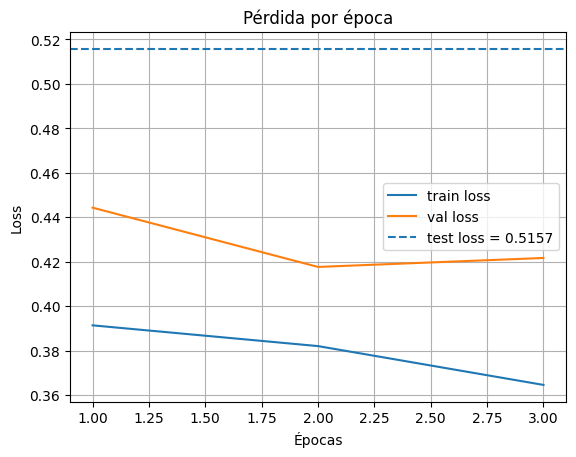

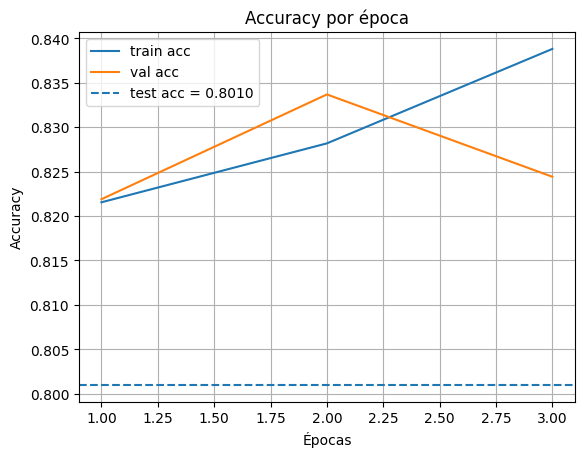

In [ ]:
# (B) PLOT: curvas train/val y línea con el valor de TEST
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets

# obtener test_dl si no existe
try:
    test_dl
except NameError:
    test_ds_full = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)
    MAX_EVAL = 2000
    n_eval = min(MAX_EVAL, len(test_ds_full))
    if n_eval < len(test_ds_full):
        rng = np.random.RandomState(42)
        idx = np.sort(rng.choice(len(test_ds_full), size=n_eval, replace=False))
        test_ds = Subset(test_ds_full, idx.tolist())
    else:
        test_ds = test_ds_full
    test_dl = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=(DEVICE.type=="cuda"))

# métricas de TEST (un solo punto)
te_loss, te_acc, (te_y, te_pred, te_prob1) = evaluate_epoch(test_dl)

epochs = np.arange(1, len(history["train_loss"]) + 1)

# --- Curva de pérdida ---
plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"],   label="val loss")
plt.axhline(y=te_loss, linestyle="--", label=f"test loss = {te_loss:.4f}")
plt.title("Pérdida por época")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

# --- Curva de accuracy ---
plt.figure()
plt.plot(epochs, history["train_acc"], label="train acc")
plt.plot(epochs, history["val_acc"],   label="val acc")
plt.axhline(y=te_acc, linestyle="--", label=f"test acc = {te_acc:.4f}")
plt.title("Accuracy por época")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()